In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import shutil
import pickle

from utils.fmri_signal_extract import signal_extract
from utils.matrix_harmonization import corr_matrix_harmonization
from utils.sliding_window_fc import dynamic_functional_connectivity


from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.maskers import NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure

/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/gruneco-server/Documents/kev_neuro/lib/python3.10/site-packages/nilearn/datasets/struct.py:378: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  warnings.warn("Default resolution of the MNI template will change "


# Dataset with demographics and img paths

In [2]:
df = pd.read_excel('/home/kevrodz/Documents/Master/scripts/ADNI3_OASIS3_demographics_filenames.xlsx')
df.head()

,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri
0,6264,M,56.5,44.0,19,1.0,4.5,12,siemens,AD,ADNI3,dswauADNI_003_S_6264.nii
1,6833,F,87.1,NaN,23,0.5,4.5,16,siemens,AD,ADNI3,dswauADNI_003_S_6833_.nii
2,6712,M,90.6,NaN,19,1.0,7.0,17,philips,AD,ADNI3,dswauADNI_019_S_6712.nii
3,6013,F,60.4,33.0,23,1.0,5.5,12,siemens,AD,ADNI3,dswauADNI_022_S_6013_.nii
4,6690,F,67.8,NaN,20,1.0,6.0,14,siemens,AD,ADNI3,dswauADNI_082_S_6690_.nii


# Load mask

## gICA 300ROI Atlas

In [3]:
# all mask by group, each mask has 15 nets (300ROI Seitzman + PMN)
# masker_GICA_300ROI = dict([('AD_ADNI','/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_ADNI3/nets_AD_ADNI3.nii'),
#                            ('CN_AD_ADNI', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_AD_ADNI3/nets_CN_AD_ADNI3.nii'),
#                            ('AD_OASIS', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/AD_OASIS3/nets_AD_OASIS3.nii'),
#                            ('CN_AD_OASIS', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_AD_OASIS3/nets_CN_AD_OASIS3.nii'),
#                            ('MCI_ADNI', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/MCI_ADNI3/nets_MCI_ADNI3.nii'),
#                            ('CN_MCI_ADNI', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/CN_MCI_ADNI3/nets_CN_MCI_ADNI3.nii')])
masker_GICA_300ROI = dict([('AD_ADNI', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_AD_ADNI3.nii'),
                           ('CN_AD_ADNI', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_CN_AD_ADNI3.nii'),
                          ('AD_OASIS', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_AD_OASIS3.nii'),
                          ('CN_AD_OASIS', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_CN_AD_OASIS3.nii'),
                          ('MCI_ADNI', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_MCI_ADNI3.nii'),
                          ('CN_MCI_ADNI', '/home/kevrodz/Documents/Master/functional_connectivity/GICA_300ROI/nets_CN_MCI_ADNI3.nii')])

## Yeo, Schaefer and Seitzman atlas

Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located at: /home/kevrodz/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


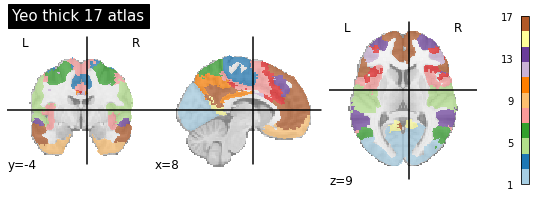

In [4]:
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
print('Yeo atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % atlas_yeo_2011.thick_17)

plotting.plot_roi(atlas_yeo_2011.thick_17, title='Yeo thick 17 atlas',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired'
                  #, output_file='Yeo_thick_17_atlas.png'
                  )

Schaefer atlas nifti image (3D) with 17 parcels and liberal mask is located at: /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz


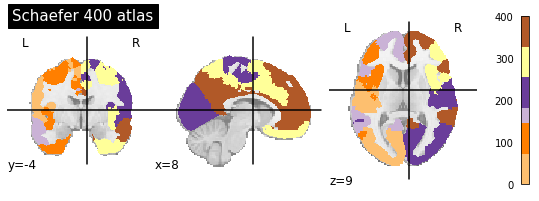

In [5]:
atlas_schaefer_2018 = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1)
# Prepend background label
atlas_schaefer_2018.labels = np.insert(atlas_schaefer_2018.labels, 0, 'Background')
print('Schaefer atlas nifti image (3D) with 17 parcels and liberal mask is located '
      'at: %s' % atlas_schaefer_2018.maps)
plotting.plot_stat_map(atlas_schaefer_2018.maps, title='Schaefer 400 atlas',
                  cut_coords=(8, -4, 9), vmax=400, cbar_tick_format='%i', colorbar=True, cmap='Paired'
                  #, output_file='Schaefer_400_atlas.png'
                    )

/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/datasets/atlas.py:1372: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))


Seitzman atlas comes with dict_keys(['rois', 'radius', 'networks', 'regions', 'description']).
Stacked power coordinates in array of shape (300, 3).


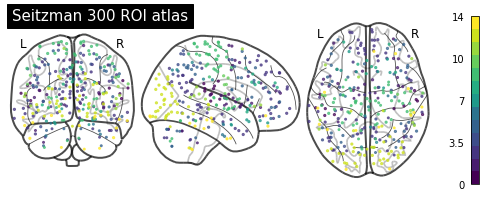

In [6]:
atlas_seitzman_300roi = datasets.fetch_coords_seitzman_2018()

print('Seitzman atlas comes with {0}.'.format(atlas_seitzman_300roi.keys()))

atlas_seitzman_300roi_coords = np.vstack((atlas_seitzman_300roi.rois['x'], atlas_seitzman_300roi.rois['y'], atlas_seitzman_300roi.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(atlas_seitzman_300roi_coords.shape))

from matplotlib.colors import ListedColormap
flat = np.column_stack(np.apply_along_axis(np.unique, 0, atlas_seitzman_300roi.networks, return_inverse=True)[1])
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(set(atlas_seitzman_300roi.networks))))
newcmp = ListedColormap(colors)


plotting.plot_markers(node_values=flat, node_size=atlas_seitzman_300roi.radius,
                      node_coords=atlas_seitzman_300roi_coords,  title='Seitzman 300 ROI atlas', node_vmin=0, node_vmax=len(newcmp.colors), node_cmap=newcmp, colorbar=True
                     #, output_file='SSeitzman_300_ROI_atlas.png'
                      )

# Images directories

In [7]:
# subjects
df_AD = df.loc[df['status'] == 'AD']
df_MCI = df.loc[df['status'] == 'MCI']
df_CN_AD = df.loc[df['status'] == 'CN_AD']
df_CN_MCI = df.loc[df['status'] == 'CN_MCI']

# Group Path
#
# path_AD_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/'
# path_AD_OASIS3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_OASIS3/'
# path_MCI_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/MCI_V2_ADNI3/'
# path_CN_AD_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_AD_ADNI3/'
# path_CN_AD_OASIS3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_OASIS3/'
# path_CN_MCI_ADNI3 = '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/CN_MCI_ADNI3/'

path_AD_ADNI3 = '/home/kevrodz/Documents/Master/ADNI3/AD/'
path_AD_OASIS3 = '/home/kevrodz/Documents/Master/OASIS3/AD_OASIS3/'
path_MCI_ADNI3 = '/home/kevrodz/Documents/Master/ADNI3/MCI/'
path_CN_AD_ADNI3 = '/home/kevrodz/Documents/Master/ADNI3/CN_AD/'
path_CN_AD_OASIS3 = '/home/kevrodz/Documents/Master/OASIS3/CN_OASIS3/'
path_CN_MCI_ADNI3 = '/home/kevrodz/Documents/Master/ADNI3/CN_MCI/'

In [8]:
paths_prefix = []
for row in df_AD.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_AD_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_AD_OASIS3)

df_AD['path'] = paths_prefix

df_AD

/tmp/ipykernel_3222/2090729601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AD['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
0,6264,M,56.50,44.0,19,1.0,4.5,12,siemens,AD,ADNI3,dswauADNI_003_S_6264.nii,/home/kevrodz/Documents/Master/ADNI3/AD/
1,6833,F,87.10,NaN,23,0.5,4.5,16,siemens,AD,ADNI3,dswauADNI_003_S_6833_.nii,/home/kevrodz/Documents/Master/ADNI3/AD/
2,6712,M,90.60,NaN,19,1.0,7.0,17,philips,AD,ADNI3,dswauADNI_019_S_6712.nii,/home/kevrodz/Documents/Master/ADNI3/AD/
3,6013,F,60.40,33.0,23,1.0,5.5,12,siemens,AD,ADNI3,dswauADNI_022_S_6013_.nii,/home/kevrodz/Documents/Master/ADNI3/AD/
4,6690,F,67.80,NaN,20,1.0,6.0,14,siemens,AD,ADNI3,dswauADNI_082_S_6690_.nii,/home/kevrodz/Documents/Master/ADNI3/AD/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,OAS31086_MR_d0065,F,76.09,34.0,30,0.5,1.5,13,siemens,AD,OASIS3,dswausub-OAS31086_ses-d0065_task-rest_run-01_b...,/home/kevrodz/Documents/Master/OASIS3/AD_OASIS3/
60,OAS31129_MR_d0055,F,68.23,34.0,29,0.5,3.0,16,siemens,AD,OASIS3,dswausub-OAS31129_ses-d0055_task-rest_run-02_b...,/home/kevrodz/Documents/Master/OASIS3/AD_OASIS3/
61,OAS31139_MR_d0533,M,85.15,34.0,26,0.5,2.5,16,siemens,AD,OASIS3,dswausub-OAS31139_ses-d0533_task-rest_run-02_b...,/home/kevrodz/Documents/Master/OASIS3/AD_OASIS3/
62,OAS31140_MR_d0332,F,88.09,34.0,23,1.0,4.5,16,siemens,AD,OASIS3,dswausub-OAS31140_ses-d0332_task-rest_run-01_b...,/home/kevrodz/Documents/Master/OASIS3/AD_OASIS3/


In [9]:
paths_prefix = []
for row in df_MCI.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_MCI_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_MCI_OASIS3)

df_MCI['path'] = paths_prefix

df_MCI

/tmp/ipykernel_3222/3256807191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MCI['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
149,6414,F,70.2,34.0,28,0.0,0.0,16,philips,MCI,ADNI3,dswauADNI_018_S_6414_.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
150,6635,F,56.6,NaN,28,0.5,1.0,18,philips,MCI,ADNI3,dswauADNI_019_S_6635.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
151,4417,M,82.1,33.0,28,0.5,0.5,16,philips,MCI,ADNI3,dswauADNI_130_S_4417_.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
152,6804,M,69.2,NaN,25,0.5,1.0,16,siemens,MCI,ADNI3,dswauADNI_032_S_6804_4D.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
153,377,M,90.3,34.0,27,0.5,1.0,16,siemens,MCI,ADNI3,dswauADNI_037_S_0377_4D.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
154,6083,M,72.2,33.0,27,0.5,0.5,12,siemens,MCI,ADNI3,dswauADNI_037_S_6083_4D.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
155,6426,F,80.8,33.0,26,0.5,1.0,14,siemens,MCI,ADNI3,dswauADNI_168_S_6426_.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
156,6467,F,71.3,33.0,27,0.5,1.0,13,siemens,MCI,ADNI3,dswauADNI_168_S_6467.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
157,6873,M,72.2,NaN,27,0.5,1.5,14,siemens,MCI,ADNI3,dswauADNI_168_S_6873_4D.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/
158,6731,F,68.2,NaN,28,0.5,2.5,20,siemens,MCI,ADNI3,dswauADNI_041_S_6731_S2020_4D.nii,/home/kevrodz/Documents/Master/ADNI3/MCI/


In [10]:
paths_prefix = []
for row in df_CN_AD.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_CN_AD_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_CN_AD_OASIS3)

df_CN_AD['path'] = paths_prefix

df_CN_AD

/tmp/ipykernel_3222/384295448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CN_AD['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
64,6227,F,62.10,33.0,30,0.0,0.0,18,siemens,CN_AD,ADNI3,dswauADNI_020_S_6227_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_AD/
65,6240,M,66.90,33.0,30,0.0,0.0,18,siemens,CN_AD,ADNI3,dswauADNI_141_S_6240_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_AD/
66,6164,F,68.90,33.0,30,0.0,0.0,20,philips,CN_AD,ADNI3,dswauADNI_100_S_6164.nii,/home/kevrodz/Documents/Master/ADNI3/CN_AD/
67,6335,M,67.20,33.0,30,0.0,0.0,19,philips,CN_AD,ADNI3,dswauADNI_177_S_6335_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_AD/
68,6813,M,67.20,NaN,29,0.0,0.0,16,siemens,CN_AD,ADNI3,dswauADNI_114_S_6813_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_AD/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,OAS30731_MR_d0044,F,72.05,23.0,27,0.0,0.0,17,siemens,CN_AD,OASIS3,dswausub-OAS30731_ses-d0044_task-rest_run-02_b...,/home/kevrodz/Documents/Master/OASIS3/CN_OASIS3/
145,OAS30780_MR_d0055,F,75.25,34.0,26,0.0,0.0,13,siemens,CN_AD,OASIS3,dswausub-OAS30780_ses-d0055_task-rest_run-01_b...,/home/kevrodz/Documents/Master/OASIS3/CN_OASIS3/
146,OAS30788_MR_d1136,F,78.09,23.0,28,0.0,0.0,13,siemens,CN_AD,OASIS3,dswausub-OAS30788_ses-d1136_task-rest_run-02_b...,/home/kevrodz/Documents/Master/OASIS3/CN_OASIS3/
147,OAS30792_MR_d1556,F,63.21,23.0,30,0.0,0.0,12,siemens,CN_AD,OASIS3,dswausub-OAS30792_ses-d1556_task-rest_run-02_b...,/home/kevrodz/Documents/Master/OASIS3/CN_OASIS3/


In [11]:
paths_prefix = []
for row in df_CN_MCI.centro:
    if row == 'ADNI3':
        paths_prefix.append(path_CN_MCI_ADNI3)
    elif row == 'OASIS3':
        paths_prefix.append(path_CN_MCI_OASIS3)

df_CN_MCI['path'] = paths_prefix

df_CN_MCI

/tmp/ipykernel_3222/207181821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CN_MCI['path'] = paths_prefix


,ID,SEXO,EDAD,APOE,MMSE,CDR_total,CDR_SOB,Escolaridad,Scanner,status,centro,rs_fmri,path
207,6191,F,55.6,NaN,30,0.0,0.0,15,siemens,CN_MCI,ADNI3,dswauADNI_070_S_6191_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
208,6008,F,65.3,33.0,29,0.0,0.0,16,siemens,CN_MCI,ADNI3,dswauADNI_141_S_6008_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
209,6104,M,70.0,34.0,30,0.0,0.0,20,general_electric,CN_MCI,ADNI3,dswauADNI_135_S_6104_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
210,6105,F,77.4,33.0,29,0.0,0.5,18,philips,CN_MCI,ADNI3,dswauADNI_130_S_6105_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
211,6629,F,57.0,NaN,30,0.0,0.0,14,siemens,CN_MCI,ADNI3,dswauADNI_082_S_6629_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
212,382,F,87.8,33.0,30,0.0,0.0,20,siemens,CN_MCI,ADNI3,dswauADNI_116_S_0382_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
213,677,M,84.0,33.0,30,0.0,0.0,18,siemens,CN_MCI,ADNI3,dswauADNI_032_S_0677_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
214,6457,M,76.7,NaN,29,0.0,0.0,18,general_electric,CN_MCI,ADNI3,dswauADNI_129_S_6457_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
215,6328,M,69.9,NaN,29,0.0,0.0,17,philips,CN_MCI,ADNI3,dswauADNI_177_S_6328_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/
216,6896,M,64.8,NaN,26,0.0,0.0,16,general_electric,CN_MCI,ADNI3,dswauADNI_021_S_6896_.nii,/home/kevrodz/Documents/Master/ADNI3/CN_MCI/


## Transform Covariables to numeric

In [12]:
def cov_to_num(df_cov, cov, cat):
    from sklearn import preprocessing
    df_covars = df_cov[cov]
    df_covars[['le_SEXO', 'SITE']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
    df_covars_num = df_covars.select_dtypes(include=np.number)
    return df_covars_num

covs = ['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']
cat = ['SEXO', 'Scanner']
df_AD_covars_num = cov_to_num(df_AD, covs, cat)
df_CN_AD_covars_num = cov_to_num(df_CN_AD, covs, cat)
df_MCI_covars_num = cov_to_num(df_MCI, covs, cat)
df_CN_MCI_covars_num = cov_to_num(df_CN_MCI, covs, cat)

/tmp/ipykernel_3222/3596943444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_3222/3596943444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_3222/3596943444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

## Group paths

In [13]:
subjects_AD_ts = df_AD.path + df_AD.rs_fmri
print(len(subjects_AD_ts))
subjects_AD_ts

64


0     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
1     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
2     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
3     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
4     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
                            ...                        
59    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
60    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
61    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
62    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
63    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
Length: 64, dtype: object

In [14]:
subjects_AD_ADNI_ts = df_AD[['path', 'rs_fmri']].loc[df_AD['centro'] == 'ADNI3']
subjects_AD_ADNI_ts = subjects_AD_ADNI_ts.path + subjects_AD_ADNI_ts.rs_fmri
subjects_AD_ADNI_ts

0     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
1     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
2     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
3     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
4     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
5     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
6     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
7     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
8     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
9     /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
10    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
11    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
12    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
13    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
14    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
15    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
16    /home/kevrodz/Documents/Master/ADNI3/AD/dswauA...
17    /home/kevrodz/Documents/Master/ADNI3/AD/ds

In [15]:
subjects_AD_OASIS_ts = df_AD[['path', 'rs_fmri']].loc[df_AD['centro'] == 'OASIS3']
subjects_AD_OASIS_ts = subjects_AD_OASIS_ts.path + subjects_AD_OASIS_ts.rs_fmri
subjects_AD_OASIS_ts

27    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
28    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
29    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
30    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
31    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
32    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
33    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
34    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
35    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
36    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
37    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
38    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
39    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
40    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
41    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
42    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
43    /home/kevrodz/Documents/Master/OASIS3/AD_OASIS...
44    /home/kevrodz/Documents/Master/OASIS3/AD_O

In [16]:
subjects_MCI_ts = df_MCI.path + df_MCI.rs_fmri

print(len(subjects_MCI_ts))
subjects_MCI_ts

58


149    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
150    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
151    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
152    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
153    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
154    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
155    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
156    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
157    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
158    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
159    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
160    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
161    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
162    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
163    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
164    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
165    /home/kevrodz/Documents/Master/ADNI3/MCI/dswau...
166    /home/kevrodz/Documents/

In [17]:
subjects_CN_MCI_ts = df_CN_MCI.path + df_CN_MCI.rs_fmri
print(len(subjects_CN_MCI_ts))
subjects_CN_MCI_ts

57


207    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
208    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
209    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
210    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
211    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
212    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
213    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
214    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
215    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
216    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
217    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
218    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
219    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
220    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
221    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
222    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
223    /home/kevrodz/Documents/Master/ADNI3/CN_MCI/ds...
224    /home/kevrodz/Documents/

In [18]:
subjects_CN_AD_ts = df_CN_AD.path + df_CN_AD.rs_fmri
print(len(subjects_CN_AD_ts))
subjects_CN_AD_ts

85


64     /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
65     /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
66     /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
67     /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
68     /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
                             ...                        
144    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
145    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
146    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
147    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
148    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
Length: 85, dtype: object

In [19]:
subjects_CN_AD_ADNI_ts = df_CN_AD[['path', 'rs_fmri']].loc[df_CN_AD['centro'] == 'ADNI3']
subjects_CN_AD_ADNI_ts = subjects_CN_AD_ADNI_ts.path + subjects_CN_AD_ADNI_ts.rs_fmri
subjects_CN_AD_ADNI_ts

64    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
65    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
66    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
67    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
68    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
69    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
70    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
71    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
72    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
73    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
74    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
75    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
76    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
77    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
78    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
79    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
80    /home/kevrodz/Documents/Master/ADNI3/CN_AD/dsw...
81    /home/kevrodz/Documents/Master/ADNI3/CN_AD

In [20]:
subjects_CN_AD_OASIS_ts = df_CN_AD[['path', 'rs_fmri']].loc[df_CN_AD['centro'] == 'OASIS3']
subjects_CN_AD_OASIS_ts = subjects_CN_AD_OASIS_ts.path + subjects_CN_AD_OASIS_ts.rs_fmri
subjects_CN_AD_OASIS_ts

93     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
94     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
95     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
96     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
97     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
98     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
99     /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
100    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
101    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
102    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
103    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
104    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
105    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
106    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
107    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
108    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
109    /home/kevrodz/Documents/Master/OASIS3/CN_OASIS...
110    /home/kevrodz/Documents/

# Signal extract

## Static and Dynamic

In [21]:
# mask = {
#         'GICA_300ROI': {
#                 'type': 'Maps',
#                 'mask': masker_GICA_300ROI,
#                 'config': None},
#         'yeo': {
#                 'type': 'Labels',
#                 'mask': atlas_yeo_2011.thick_17,
#                 'config': None},
#         'schaefer': {
#                 'type': 'Labels',
#                 'mask': atlas_schaefer_2018.maps,
#                 'config': None},
#         'seitzman_300ROI': {
#                 'type': 'Spheres',
#                 'mask': atlas_seitzman_300roi.rois,
#                 'config': {'radius': 5}}
#         }
mask = {
        'schaefer': {
                 'type': 'Labels',
                 'mask': atlas_schaefer_2018.maps,
                 'config': None},
        'seitzman_300ROI': {
                'type': 'Spheres',
                'mask': atlas_seitzman_300roi.rois,
                'config': {'radius': 5}}
        }
# metrics = ['correlation', 'covariance', 'partial correlation']
metrics = ['partial correlation']

subj_repo_ts = [subjects_AD_ADNI_ts, subjects_CN_AD_ADNI_ts, subjects_AD_OASIS_ts,
           subjects_CN_AD_OASIS_ts, subjects_MCI_ts, subjects_CN_MCI_ts]

subj_harm_ts = [subjects_AD_ts, subjects_CN_AD_ts, subjects_MCI_ts, subjects_CN_MCI_ts]
#
# subj_group_config = {
#         'AD_ADNI': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('AD_ADNI'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'AD',
#                 'tr': 3
#                 },
#         'CN_AD_ADNI': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('CN_AD_ADNI'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'CN_AD',
#                 'tr': 3
#                 },
#         'AD_OASIS': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('AD_OASIS'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'AD',
#                 'tr': 2.2
#                 },
#         'CN_AD_OASIS': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('CN_AD_OASIS'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'CN_AD',
#                 'tr': 2.2
#                 },
#         'MCI_ADNI': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('MCI_ADNI'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'MCI',
#                 'tr': 3
#                 },
#         'CN_MCI_ADNI': {
#                 'atlas': [mask.get('GICA_300ROI').get('mask').get('CN_MCI_ADNI'), mask.get('yeo').get('mask'), mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
#                 'mask_type': [mask.get('GICA_300ROI').get('type'), mask.get('yeo').get('type'), mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
#                 'group': 'CN_MCI',
#                 'tr': 3
#                 }
#         }


subj_group_config = {
        'AD_ADNI': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'AD',
                'tr': 3
                },
        'CN_AD_ADNI': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'CN_AD',
                'tr': 3
                },
        'AD_OASIS': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'AD',
                'tr': 2.2
                },
        'CN_AD_OASIS': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'CN_AD',
                'tr': 2.2
                },
        'MCI_ADNI': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'MCI',
                'tr': 3
                },
        'CN_MCI_ADNI': {
                'atlas': [mask.get('schaefer').get('mask'), mask.get('seitzman_300ROI').get('mask')],
                'mask_type': [mask.get('schaefer').get('type'), mask.get('seitzman_300ROI').get('type')],
                'group': 'CN_MCI',
                'tr': 3
                }
        }
subj_group_config.keys()

dict_keys(['AD_ADNI', 'CN_AD_ADNI', 'AD_OASIS', 'CN_AD_OASIS', 'MCI_ADNI', 'CN_MCI_ADNI'])

In [22]:
def extract_fc(subj, mask, mask_type, kind, fname, config: dict = {}, save_results=True):
    from numpy import savetxt
    import os
    import shutil
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    config = config if config is not None else {}
    fname = fname + f'/{kind.replace(" ", "_")}'
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    ts, roi_img, labels, masker_type = signal_extract(subj, mask, masker_type=mask_type, config=config)
    #print(ts)
    row=len(ts)
    column=len(ts[0])
    print(f'Rows:{row}, Column:{column}')
    print("Shape of a list (ts):",len(ts))
    connectome_measure = ConnectivityMeasure(kind=kind)
    correlation_matrices = connectome_measure.fit_transform(ts)
    mean_correlation_matrix = connectome_measure.mean_

    # correlation_matricesReshaped = correlation_matrices.reshape(correlation_matrices.shape[0], -1)
    # correlation_matricesReshaped.to_csv('/home/kevrodz/Documents/Master/scripts/connectome_measure_corr.csv', index=False)

    if save_results:
        # Create the folder
        if not os.path.exists(fname):
            os.makedirs(fname)
        else:
            shutil.rmtree(fname)  # Removes all the subdirectories
            os.makedirs(fname)
        # Save the conn matrix into their respective folder
        for i in range(correlation_matrices.shape[0]):
            savetxt(f'{fname}/subj_{i}_connectome_measure_{kind.replace(" ", "_")}.csv', correlation_matrices[i], delimiter=',')
        savetxt(f'{fname}/subj_all_connectome_measure_mean_{kind.replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')
    #connectome_measure_cov = ConnectivityMeasure(kind='covariance')  # covariance
    #connectome_measure_pcorr = ConnectivityMeasure(kind='partial correlation')  # partial correlation
    return correlation_matrices, mean_correlation_matrix

def extract_dyn_fc(slwin_ts, kind):
    sw_ts = list()
    for w in range(slwin_ts.shape[1]): # n_window
        sw_ts = list()
        for subj in range(slwin_ts.shape[0]): # subject
            sw_ts.append(slwin_ts[subj][w])
    connectome_measure = ConnectivityMeasure(kind=kind)
    correlation_matrices = connectome_measure.fit_transform(sw_ts)
    mean_correlation_matrix = connectome_measure.mean_

    return correlation_matrices, mean_correlation_matrix

In [ ]:
# Raw (no harmonization)
for idx, val in enumerate(subj_group_config.keys()):
    for idx_mask, mask_value in enumerate(mask.keys()):
        for idx_metric, metric_value in enumerate(metrics):
           print(val, mask_value, metric_value)
           correlation_matrices, mean_correlation_matrix = extract_fc(subj=subj_repo_ts[idx],
                                                                       mask=subj_group_config.get(val).get('atlas')[idx_mask],
                                                                       mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
                                                                       kind=metrics[idx_metric],
                                                                       fname=f'/home/kevrodz/Documents/Master/functional_connectivity/static/FC_{val}/{mask_value}/{metric_value}/',
                                                                       config=mask.get(mask_value).get('config'),
                                                                       save_results=True)

In [22]:
len(subj_harm_ts)

4

In [23]:
ts_AD, corr_AD, mean_corr_AD, wl_dim_AD = [], [], [], []
ts_CN_AD, corr_CN_AD, mean_corr_CN_AD, wl_dim_CN_AD = [], [], [], []
ts_MCI, corr_MCI, mean_corr_MCI, wl_dim_MCI = [], [], [], []
ts_CN_MCI, corr_CN_MCI, mean_corr_CN_MCI, wl_dim_CN_MCI = [], [], [], []
ts_mask = {'GICA_300ROI': {},
                      'yeo': {},
                      'schaefer': {},
                      'seitzman_300ROI': {}}
ts_group = {
        'AD': {'ts': [],
               'cov': df_AD,
               'cov_num': df_AD_covars_num,
               'corr_matrix': {},
               'corr': [],
               'mean_corr': [],
               'wl_dim': wl_dim_AD,
               'harmonization': True,
                  'windows': {},
               'harm_corr': {}},
        'CN_AD': {'ts': [],
               'cov': df_CN_AD,
               'cov_num': df_CN_AD_covars_num,
                  'corr': [],
                  'mean_corr': [],
               'wl_dim': wl_dim_CN_AD,
               'harmonization': True,
                  'windows': {},
               'harm_corr': {}},
        'MCI': {'ts': [],
               'cov': df_MCI,
               'cov_num': df_MCI_covars_num,
                'corr': [],
                'mean_corr': [],
               'wl_dim': wl_dim_MCI,
               'harmonization': False,
                  'windows': {},
               'harm_corr': {}},
        'CN_MCI': {'ts': [],
               'cov': df_CN_MCI,
               'cov_num': df_CN_MCI_covars_num,
                   'corr': [],
                   'mean_corr': [],
               'wl_dim': wl_dim_CN_MCI,
               'harmonization': False,
                  'windows': {},
               'harm_corr': {}}
        }

# TEST IMG
# subj_repo_ts = [subjects_AD_ADNI_ts[:9], subjects_CN_AD_ADNI_ts[:2], subjects_AD_OASIS_ts[:2],
#            subjects_CN_AD_OASIS_ts[:2], subjects_MCI_ts[:2], subjects_CN_MCI_ts[:2]]

In [24]:
ts_group

{'AD': {'ts': [],
  'cov':                    ID SEXO   EDAD  APOE  MMSE  CDR_total  CDR_SOB  \
  0                6264    M  56.50  44.0    19        1.0      4.5   
  1                6833    F  87.10   NaN    23        0.5      4.5   
  2                6712    M  90.60   NaN    19        1.0      7.0   
  3                6013    F  60.40  33.0    23        1.0      5.5   
  4                6690    F  67.80   NaN    20        1.0      6.0   
  ..                ...  ...    ...   ...   ...        ...      ...   
  59  OAS31086_MR_d0065    F  76.09  34.0    30        0.5      1.5   
  60  OAS31129_MR_d0055    F  68.23  34.0    29        0.5      3.0   
  61  OAS31139_MR_d0533    M  85.15  34.0    26        0.5      2.5   
  62  OAS31140_MR_d0332    F  88.09  34.0    23        1.0      4.5   
  63  OAS31134_MR_d0019    F  76.77  34.0    25        0.5      3.0   
  
      Escolaridad  Scanner status  centro  \
  0            12  siemens     AD   ADNI3   
  1            16  siemens    

In [25]:
def extract_harm_ts(subj, mask, mask_type, config: dict = {}):
    from numpy import savetxt
    import os
    import shutil
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    config = config if config is not None else {}
    # ts shape (n_subjects), and in each subject shape (vols, rois)
    ts, roi_img, labels, masker_type = signal_extract(subj, mask, masker_type=mask_type, config=config)

    return ts, roi_img, labels, masker_type

In [ ]:
# Dynamic (harmonization)

for idx_mask, mask_value in enumerate(mask.keys()):
    for idx_metric, metric_value in enumerate(metrics):
        wl_dim = list()
        n_slwin_flag = list()  # number of sliding window flag
        slwin_ts_list = []
        for idx, val in enumerate(subj_group_config.keys()):
            # Extract time series for each group by each mask
            #fname = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_{val}/{mask_value}/{metric_value.replace(" ", "_")}/'
            #fname = fname + f'{metrics[idx_metric].replace(" ", "_")}'
            ts, roi_img, labels, masker_type = extract_harm_ts(subj=subj_repo_ts[idx],
                                                               mask=subj_group_config.get(val).get('atlas')[idx_mask],
                                                               mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
                                                               config=mask.get(mask_value).get('config'))
            if subj_group_config.get(val).get('group') == 'AD':
                ts_group.get('AD').get('ts').extend(ts)
            elif subj_group_config.get(val).get('group') == 'CN_AD':
                ts_group.get('CN_AD').get('ts').extend(ts)
            elif subj_group_config.get(val).get('group') == 'MCI':
                ts_group.get('MCI').get('ts').extend(ts)
            elif subj_group_config.get(val).get('group') == 'CN_MCI':
                ts_group.get('CN_MCI').get('ts').extend(ts)

            print('_________________________________________________')
            print(val, mask_value)
            row = len(ts_group.get(subj_group_config.get(val).get('group')).get('ts'))
            column = len(ts_group.get(subj_group_config.get(val).get('group')).get('ts')[0])
            #print(f'{val} Rows:{row}, Column:{column}')
            #print("Shape of a list (ts): ", len(ts_group.get(subj_group_config.get(val).get('group')).get('ts')))
            print('__________________________________________________')
            #print(f'lenght ts (subjects): {len(ts)}')
            #np_ts = np.asarray(ts)

            #wl = round(column / ((subj_group_config.get(val).get('tr') * column) / 60))  # window length in vols (60 seconds)
            # window length in vols
            wl = int(subj_group_config.get(val).get('tr') * 10) # 10TR (time change by repository)
            ss = round(wl / 2)  # window step size in vols
            print(f'wl: {wl}, ss: {ss}')
            #print(f'>>>>> np_ts -- shape: {np_ts.shape} 0-subj: {np_ts.shape[0]}, 1-vols: {np_ts.shape[1]}, 2-roi: {np_ts.shape[2]}')
            #print(f'>>>>> np_ts -- shape: {np_ts.shape}')
            for i in range(len(ts)):
                slwin_ts_ind, n_slwin = dynamic_functional_connectivity(np.reshape(np.asarray(ts[i]), (1, np.asarray(ts[i]).shape[0], np.asarray(ts[i]).shape[1])), wl, ss, 'hann')  # Windowed BOLD time-series
                #print(f'>>> SHAPE: {slwin_ts_ind.shape}, #sw: {n_slwin}')
                slwin_ts_list.append(slwin_ts_ind)
                #print(f'longitud final: {len(slwin_ts)}')

            slwin_ts = np.reshape(np.asarray(slwin_ts_list), (len(slwin_ts_list), n_slwin, slwin_ts_ind.shape[2], slwin_ts_ind.shape[3]))
            slwin_ts_list = []
            #slwin_ts, n_slwin = dynamic_functional_connectivity(np_ts, wl, ss, 'hann')  # Windowed BOLD time-series
            print(f'Number sliding windows: {n_slwin}')
            #print(f'Shape {slwin_ts.shape}')  #(subjects, windows, window length, rois)
            n_slwin_flag.append(n_slwin)
            #print(f'n_slwin_flag: {n_slwin_flag}')
            print(idx_metric, metric_value)
            #correlation_matrices, mean_correlation_matrix = extract_dyn_fc(slwin_ts, metrics[idx_metric])
            n = 0
            if n_slwin > min(n_slwin_flag):
                n = abs(n_slwin - min(n_slwin_flag))
                #print(f'number of windows (n) to reduce: {n}')
                #correlation_matrices = correlation_matrices[ : -n]
                #print(f'correlation_matrices shape after reduction: {correlation_matrices.shape}')


            #fname = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_{val}/{mask_value}/'
            sw_ts = list()
            for w in range(slwin_ts.shape[1] - n): # network
                sw_ts = list()
                for subj in range(slwin_ts.shape[0]): # subject
                    sw_ts.append(slwin_ts[subj][w])
                connectome_measure = ConnectivityMeasure(kind=metrics[idx_metric])
                correlation_matrices = connectome_measure.fit_transform(sw_ts)
                mean_correlation_matrix = connectome_measure.mean_
                #print(f'correlation_matrices shape: {correlation_matrices.shape}')


                fname = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_{val}/{mask_value}/{metric_value.replace(" ", "_")}/w_{w:02}/'
                # Create the folder for un-harmonized data
                if not os.path.exists(fname):
                    os.makedirs(fname)
                else:
                    shutil.rmtree(fname)  # Removes all the subdirectories
                    os.makedirs(fname)
                # Save the conn matrix into their respective folder
                for i in range(correlation_matrices.shape[0]):
                    np.savetxt(f'{fname}subj_{i}_w_{w:02}_connectome_measure_{metrics[idx_metric].replace(" ", "_")}.csv', correlation_matrices[i], delimiter=',')
                np.savetxt(f'{fname}subj_all_w_{w:02}_connectome_measure_mean_{metrics[idx_metric].replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')

                if subj_group_config.get(val).get('group') == 'AD':
                    ts_group.get('AD').get('corr').extend(correlation_matrices)
                    ts_group.get('AD').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('AD').get('wl_dim').append(n_slwin)
                elif subj_group_config.get(val).get('group') == 'CN_AD':
                    ts_group.get('CN_AD').get('corr').extend(correlation_matrices)
                    ts_group.get('CN_AD').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('CN_AD').get('wl_dim').append(n_slwin)
                elif subj_group_config.get(val).get('group') == 'MCI':
                    ts_group.get('MCI').get('corr').extend(correlation_matrices)
                    ts_group.get('MCI').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('MCI').get('wl_dim').append(n_slwin)
                elif subj_group_config.get(val).get('group') == 'CN_MCI':
                    ts_group.get('CN_MCI').get('corr').extend(correlation_matrices)
                    ts_group.get('CN_MCI').get('mean_corr').extend(mean_correlation_matrix)
                    ts_group.get('CN_MCI').get('wl_dim').append(n_slwin)
                #coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img='/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/nets_CN_ADNI3.nii')
                #plotting.plot_connectome(mean_correlation_matrix, coordinates, edge_threshold="90%", edge_vmax=.5, edge_vmin=-.5,title='GICA_300ROI with {} nets. Window {}'.format(15, w))
                #plotting.show()


        #print(f'FINAL WINDOWS: {min(n_slwin_flag)}')

        for idx_group, group_value in enumerate(ts_group.keys()):
            for idx_w in range(min(n_slwin_flag)): # each window
                shap = np.asarray(ts_group.get(group_value).get('corr')).shape[0]
                print(f'>>GROUP: {group_value} , W: {idx_w}, shape: {shap}')
                idx_subj_window = np.arange(idx_w, np.asarray(ts_group.get(group_value).get('corr')).shape[0], min(n_slwin_flag))  # select al the subject windows
                #print(idx_subj_window)
                ts_group.get(group_value).get('windows')[idx_w] = np.asarray(ts_group.get(group_value).get('corr'))[idx_subj_window, :, :]

                # Harmonization is returning NaN :(
                # if ts_group.get(group_value).get('harmonization') == True:
                #     my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=ts_group.get(group_value).get('windows').get(metric_value)[idx_w],
                #                                                                           cov=ts_group.get(group_value).get('cov_num').head(idx_subj_window.shape[0]),
                #                                                                           v=0)
                #     ts_group.get(group_value).get('harm_corr').get(metric_value)[idx_w] = correlation_matrices_harmonized

                fname_all = f'/home/kevrodz/Documents/Master/functional_connectivity/dynamic/FC_ALL_{group_value}/{mask_value}/{metric_value.replace(" ", "_")}/w_{idx_w:02}/'
                # Create the folder for harmonized data
                if not os.path.exists(fname_all):
                    os.makedirs(fname_all)
                else:
                    shutil.rmtree(fname_all)  # Removes all the subdirectories
                    os.makedirs(fname_all)
                # Save the conn matrix into their respective folder
                for i in range(ts_group.get(group_value).get('windows').get(idx_w).shape[0]):
                    np.savetxt(f'{fname_all}subj_{i}_w_{idx_w:02}_connectome_measure_{metrics[idx_metric].replace(" ", "_")}.csv', ts_group.get(group_value).get('windows').get(idx_w)[i], delimiter=',')
                #np.savetxt(f'{fname_all}subj_all_w_{idx_w:02}_connectome_measure_mean_{metrics[idx_metric].replace(" ", "_")}.csv', mean_correlation_matrix, delimiter=',')

        np.save(f'/home/kevrodz/Documents/Master/functional_connectivity/ts_group_{mask_value}_{metric_value.replace(" ", "_")}.npy',  ts_group)
        pickle.dump(ts_group, open(f'/home/kevrodz/Documents/Master/functional_connectivity/ts_group_{mask_value}_{metric_value.replace(" ", "_")}.pickle', "wb"), protocol=pickle.HIGHEST_PROTOCOL)  # save it into a file named ts_group.pickle
        ts_group.get('AD')['ts'] = []
        ts_group.get('CN_AD')['ts'] = []
        ts_group.get('MCI')['ts'] = []
        ts_group.get('CN_MCI')['ts'] = []

        ts_group.get('AD')['corr_matrix'] = {}
        ts_group.get('CN_AD')['corr_matrix'] = {}
        ts_group.get('MCI')['corr_matrix'] = {}
        ts_group.get('CN_MCI')['corr_matrix'] = {}

        ts_group.get('AD')['corr'] = []
        ts_group.get('CN_AD')['corr'] = []
        ts_group.get('MCI')['corr'] = []
        ts_group.get('CN_MCI')['corr'] = []

        ts_group.get('AD')['mean_corr'] = []
        ts_group.get('CN_AD')['mean_corr'] = []
        ts_group.get('MCI')['mean_corr'] = []
        ts_group.get('CN_MCI')['mean_corr'] = []

        ts_group.get('AD')['wl_dim'] = []
        ts_group.get('CN_AD')['wl_dim'] = []
        ts_group.get('MCI')['wl_dim'] = []
        ts_group.get('CN_MCI')['wl_dim'] = []

        ts_group.get('AD')['windows'] = {}
        ts_group.get('CN_AD')['windows'] = {}
        ts_group.get('MCI')['windows'] = {}
        ts_group.get('CN_MCI')['windows'] = {}

        ts_group.get('AD')['harm_corr'] = {}
        ts_group.get('CN_AD')['harm_corr'] = {}
        ts_group.get('MCI')['harm_corr'] = {}
        ts_group.get('CN_MCI')['harm_corr'] = {}
        #break
    #break


           # print(val, mask_value, metric_value)
           # correlation_matrices, mean_correlation_matrix = extract_fc(subj=subj_harm_ts[idx],
           #                                                             mask=subj_group_config.get(val).get('atlas')[idx_mask],
           #                                                             mask_type=subj_group_config.get(val).get('mask_type')[idx_mask],
           #                                                             kind=metrics[idx_metric],
           #                                                             fname=f'/home/kevrodz/Documents/Master/functional_connectivity/static/FC_{val}/{mask_value}/{metric_value}/',
           #                                                             config=mask.get(mask_value).get('config'),
           #                                                             save_results=True)
           # if
           # my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=correlation_matrices, cov=df_covars_num, v=0)


In [132]:
#ts_group.get('AD').get('windows')[0] = np.asarray(ts_group.get('AD').get('corr'))[[ 1, 12, 23, 34, 45, 56, 67, 78], :, :]
ts_group.get('AD').get('windows').keys()

dict_keys([])

In [83]:
# Load data (deserialize)
with open('/home/kevrodz/Documents/Master/functional_connectivity/ts_group_GICA_300ROI_correlation.pickle', 'rb') as handle:
    ts_group_data = pickle.load(handle)
ts_group_data.get('AD').get('windows').get(0)[0]

array([[ 1.00000000e+00,  5.93432383e-01, -3.33135142e-02,
        -2.97018345e-01, -4.19444986e-01, -1.24147726e-01,
         2.66144517e-01,  5.49700373e-01, -4.15186911e-01,
         3.04323366e-01, -2.03320766e-01,  3.24631374e-01,
        -1.85237381e-01,  2.77053402e-02, -1.17070732e-01],
       [ 5.93432383e-01,  1.00000000e+00, -1.41618895e-01,
        -1.10994664e-01, -5.14613746e-01, -2.62302377e-01,
         2.41305263e-01,  4.97591817e-01, -4.44351966e-01,
         4.76258703e-01, -2.48606212e-01,  3.48401380e-01,
        -2.32777712e-01, -7.76610018e-02, -2.56493407e-01],
       [-3.33135142e-02, -1.41618895e-01,  1.00000000e+00,
        -2.33178950e-01, -1.38782340e-02, -4.47389025e-01,
         3.66570380e-01,  2.56712659e-01, -2.65634437e-01,
         7.18331731e-02,  4.63351051e-01,  2.96925811e-01,
        -1.13797459e-01,  5.19020995e-01, -3.51193740e-01],
       [-2.97018345e-01, -1.10994664e-01, -2.33178950e-01,
         1.00000000e+00, -1.27987224e-01,  2.58245161

In [88]:
df_AD_test = df_AD[df_AD['centro']=='ADNI3'].head(2).append(df_AD[df_AD['centro']=='OASIS3'].head(2), ignore_index=True)
df_AD_test_covars_num = cov_to_num(df_AD_test, covs, cat)
df_AD_test_covars_num

/tmp/ipykernel_31593/3545881244.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_AD_test = df_AD[df_AD['centro']=='ADNI3'].head(2).append(df_AD[df_AD['centro']=='OASIS3'].head(2), ignore_index=True)
/tmp/ipykernel_31593/3596943444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covars[['le_SEXO', 'SITE']] = df_covars[cat].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_31593/3596943444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,EDAD,MMSE,CDR_SOB,CDR_total,Escolaridad,le_SEXO,SITE
0,56.50,19,4.5,1.0,12,1,0
1,87.10,23,4.5,0.5,16,0,0
2,78.06,25,5.0,1.0,11,1,0
3,76.69,23,3.5,0.5,12,0,0


In [91]:
my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=ts_group_data.get('AD').get('windows').get(0),
                                                                                           cov=df_AD_test_covars_num,
                                                                                           v=0)
correlation_matrices_harmonized

LinAlgError: Singular matrix

In [96]:
ts_group_data.get('AD').get('windows').get(0).shape

(8, 15, 15)

In [79]:
ts_group_data_numpy = np.load('/home/kevrodz/Documents/Master/functional_connectivity/ts_group_GICA_300ROI_correlation.npy', allow_pickle=True)
ts_group_data_numpy.item().get('AD').get('windows').keys()

array([[[ 1.        ,  0.59343238, -0.03331351, ..., -0.18523738,
          0.02770534, -0.11707073],
        [ 0.59343238,  1.        , -0.1416189 , ..., -0.23277771,
         -0.077661  , -0.25649341],
        [-0.03331351, -0.1416189 ,  1.        , ..., -0.11379746,
          0.519021  , -0.35119374],
        ...,
        [-0.18523738, -0.23277771, -0.11379746, ...,  1.        ,
          0.25350985,  0.44070765],
        [ 0.02770534, -0.077661  ,  0.519021  , ...,  0.25350985,
          1.        , -0.00997276],
        [-0.11707073, -0.25649341, -0.35119374, ...,  0.44070765,
         -0.00997276,  1.        ]],

       [[ 1.        , -0.03058834, -0.16927568, ..., -0.19785323,
         -0.34138651, -0.06302459],
        [-0.03058834,  1.        , -0.48022031, ...,  0.18349561,
         -0.19528064, -0.13879856],
        [-0.16927568, -0.48022031,  1.        , ..., -0.01281605,
          0.38635833,  0.06700199],
        ...,
        [-0.19785323,  0.18349561, -0.01281605, ...,  

In [118]:
#ts_group.get('AD').get('harm_corr')[9][0]
a={'AD':{}}
a.get('AD')['300roi'] = [1,2,3]
a.get('AD').get(

{'AD': {'300roi': [1, 2, 3]}}

In [86]:
ts_group.get('AD').get('windows').keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [82]:
#slwin_ts.shape[1]
#correlation_matrices.shape
#len(ts_group.get('AD').get('corr'))
#ts_group.get('AD').get('corr')[0]
a = np.asarray(ts_group.get('AD').get('corr'))
b = a[[ 0, 11, 22, 33], :, :]
b[1]

array([[ 1.        , -0.24835756,  0.29966276, -0.12977499,  0.36350277,
        -0.0619268 ,  0.04265811,  0.04428521, -0.20300294, -0.068191  ,
        -0.03640443, -0.3196513 , -0.16691581,  0.34987422,  0.01191218],
       [-0.24835756,  1.        , -0.42569559,  0.23243859, -0.17631715,
         0.361645  ,  0.08596453, -0.0201309 , -0.18285448,  0.06280165,
        -0.02865964,  0.21171092,  0.35911031, -0.2506255 ,  0.17285679],
       [ 0.29966276, -0.42569559,  1.        , -0.23199671,  0.12519917,
        -0.33940796, -0.0587479 , -0.06125233, -0.01222717, -0.08836445,
        -0.13454342, -0.32532116, -0.30621688,  0.39941827, -0.21168657],
       [-0.12977499,  0.23243859, -0.23199671,  1.        , -0.13696179,
         0.10174684, -0.15831928,  0.28805808, -0.11843446, -0.08240969,
         0.17955529,  0.3400529 ,  0.24938437, -0.065346  ,  0.240336  ],
       [ 0.36350277, -0.17631715,  0.12519917, -0.13696179,  1.        ,
         0.03168049, -0.11534444,  0.02263241, 

In [66]:
ts_group_AD = np.asarray(ts_group.get('AD').get('corr'))
print(f'original: {ts_group_AD.shape}')
min_win = min(ts_group.get('AD').get('wl_dim'))
print(f'min win: {min_win}')
ts_group_AD[33]

original: (44, 15, 15)
min win: 11


array([[ 1.        ,  0.62552156, -0.27418848, -0.67633691,  0.30865399,
         0.6045393 ,  0.08710688, -0.37911183, -0.39101523, -0.44434676,
         0.28131671,  0.41993087,  0.58691472,  0.41634352,  0.56847685],
       [ 0.62552156,  1.        , -0.27689783, -0.73448964,  0.05350123,
         0.69346335,  0.04193936, -0.46411145, -0.46866915, -0.57230246,
         0.29671363,  0.55857951,  0.62140342,  0.6415226 ,  0.62080583],
       [-0.27418848, -0.27689783,  1.        ,  0.34894957, -0.08715144,
        -0.48871654,  0.4218364 , -0.14717873,  0.73035158,  0.30753366,
         0.32981958,  0.23423077, -0.53578535, -0.0136982 , -0.41340485],
       [-0.67633691, -0.73448964,  0.34894957,  1.        , -0.22829945,
        -0.7607469 , -0.03124366,  0.53613719,  0.57179054,  0.62906629,
        -0.33280327, -0.57104822, -0.69101321, -0.62011665, -0.68164752],
       [ 0.30865399,  0.05350123, -0.08715144, -0.22829945,  1.        ,
         0.19712534,  0.20911284, -0.22487632, 

In [87]:
df_AD_covars = df_AD[['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']]

from sklearn import preprocessing

df_AD_covars[['le_SEXO', 'SITE']] = df_AD_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
df_AD_covars_num = df_AD_covars.select_dtypes(include=np.number)
df_AD_covars_num

/tmp/ipykernel_10538/13748257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AD_covars[['le_SEXO', 'SITE']] = df_AD_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
/tmp/ipykernel_10538/13748257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AD_covars[['le_SEXO', 'SITE']] = df_AD_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)


,EDAD,MMSE,CDR_SOB,CDR_total,Escolaridad,le_SEXO,SITE
0,56.50,19,4.5,1.0,12,1,2
1,87.10,23,4.5,0.5,16,0,2
2,90.60,19,7.0,1.0,17,1,1
3,60.40,23,5.5,1.0,12,0,2
4,67.80,20,6.0,1.0,14,0,2
...,...,...,...,...,...,...,...
59,76.09,30,1.5,0.5,13,0,2
60,68.23,29,3.0,0.5,16,0,2
61,85.15,26,2.5,0.5,16,1,2
62,88.09,23,4.5,1.0,16,0,2


In [108]:
#ts_group.get('AD').get('corr')[45]
#my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=ts_group.get('AD').get('windows').get(0), cov=df_AD_covars_num.head(4), v=0)



my_model, correlation_matrices_harmonized = corr_matrix_harmonization(corr=ts_group.get('CN_AD').get('windows')[0],
                                                                                          cov=ts_group.get('CN_AD').get('cov_num').head(4),
                                                                                          v=0)
correlation_matrices_harmonized

/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [105]:
ts_group.get(group_value).get('cov_num').head(4)

,EDAD,MMSE,CDR_SOB,CDR_total,Escolaridad,le_SEXO,SITE
64,62.1,30,0.0,0.0,18,0,2
65,66.9,30,0.0,0.0,18,1,2
66,68.9,30,0.0,0.0,20,0,1
67,67.2,30,0.0,0.0,19,1,1


In [52]:
np.asarray(ts_group.get('AD').get('corr')).shape

(44, 15, 15)

In [68]:
a = np.asarray(ts_group.get('AD').get('corr'))
b = a[0:2,:,:]
#b[1]
#w0: 0 11 21 31
w_0 = np.arange(0, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_0)
w_1 = np.arange(1, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_1)
w_10 = np.arange(10, np.asarray(ts_group.get('AD').get('corr')).shape[0], 11)
print(w_10)
#ts_group.get('AD').get('corr')[43]

for idx_w in range(min(n_slwin_flag)):
    w = np.arange(idx_w, np.asarray(ts_group.get('AD').get('corr')).shape[0], min(n_slwin_flag))
    print(w)
    print(w.shape)
    print(w[1])

[ 0 11 22 33]
[ 1 12 23 34]
[10 21 32 43]
[ 0 11 22 33]
(4,)
11
[ 1 12 23 34]
(4,)
12
[ 2 13 24 35]
(4,)
13
[ 3 14 25 36]
(4,)
14
[ 4 15 26 37]
(4,)
15
[ 5 16 27 38]
(4,)
16
[ 6 17 28 39]
(4,)
17
[ 7 18 29 40]
(4,)
18
[ 8 19 30 41]
(4,)
19
[ 9 20 31 42]
(4,)
20
[10 21 32 43]
(4,)
21


In [ ]:
# correlation_matrices, mean_correlation_matrix = extract_fc(subjects_AD_OASIS_ts,
                                                           masker_GICA_300ROI.get('AD_OASIS'),
                                                           'Maps',
                                                           'correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/static/FC_AD_OASIS/GIGA_300ROI/')

In [ ]:
correlation_matrices, mean_correlation_matrix = extract_fc(subjects_AD_OASIS_ts,
                                                           masker_GICA_300ROI.get('AD_OASIS'),
                                                           'Maps',
                                                           'covariance',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/static/FC_AD_OASIS/GIGA_300ROI/')

In [ ]:
correlation_matrices, mean_correlation_matrix = extract_fc(subjects_AD_OASIS_ts,
                                                           masker_GICA_300ROI.get('AD_OASIS'),
                                                           'Maps',
                                                           'partial correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/static/FC_AD_OASIS/GIGA_300ROI/')

In [ ]:
df_AD_covars = df_AD[['SEXO', 'EDAD', 'Scanner', 'MMSE', 'CDR_SOB', 'CDR_total', 'Escolaridad', 'centro']]

df_AD_covars[['le_SEXO', 'SITE']] = df_AD_covars[['SEXO', 'Scanner']].apply(preprocessing.LabelEncoder().fit_transform)
df_AD_covars_num = df_AD_covars.select_dtypes(include=np.number)
df_AD_covars_num

In [ ]:
ts, roi_img, labels, masker_type = signal_extract(subjects_AD_OASIS_ts, mask.get('schaefer').get('mask'), masker_type='Maps')

In [28]:
correlation_matrices, mean_correlation_matrix = extract_fc(subjects_AD_OASIS_ts,
                                                           mask.get('schaefer').get('mask'),
                                                           'Labels',
                                                           'correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/FC_AD_OASIS/GIGA_300ROI/')

  400 region(s) detected from /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_OASIS3/dswausub-OAS30064_ses-d0687_task-rest_run-01_bold.nii', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': <nibabel.nifti1.Nifti1Image object at 0x7fec73a429e0>,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiLabelsMasker.transform_single_imgs] Load

UnboundLocalError: local variable 'labels' referenced before assignment

In [31]:
correlation_matrices

array([[[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]]], dtype=float32)

In [24]:

subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6264_v164_.nii']

correlation_matrices, mean_correlation_matrix = extract_fc(subjects_ts,
                                                           mask.get('yeo').get('mask'),
                                                           'Labels',
                                                           'correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/FC_AD_OASIS/labeltest/')

  17 region(s) detected from /home/kevrodz/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/kevrodz/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/home/kevrodz/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz',
  'low_pass': None,
  'mask_img': <nibabel.nifti1.Nifti1Image object at 0x7f258b227dc0>,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiLabelsMasker.transform_single_imgs]

In [27]:
correlation_matrices[1]

array([[ 1.00000000e+00, -4.87282425e-02, -4.01142947e-02,
        -1.53001711e-01,  1.20260522e-01, -1.31724685e-01,
        -1.21488713e-01,  4.45679277e-02,  2.06530645e-01,
         1.99049667e-01, -1.03185274e-01,  1.31529391e-01,
         1.11330070e-01, -2.37488359e-01, -1.38482466e-01,
         7.84525927e-03,  3.18685733e-02],
       [-4.87282425e-02,  1.00000000e+00,  4.07469213e-01,
        -2.52878275e-02, -4.70883660e-02,  6.43334314e-02,
        -2.46298105e-01, -1.66455701e-01, -2.37506256e-02,
        -3.77145633e-02,  4.48664516e-01, -2.77643323e-01,
        -1.51287436e-01, -1.96875826e-01,  2.23506808e-01,
         2.35212311e-01,  1.39893651e-01],
       [-4.01142947e-02,  4.07469213e-01,  1.00000000e+00,
         2.90959895e-01,  7.53297582e-02,  5.13569236e-01,
         7.93470070e-02, -4.48833220e-02, -1.43202385e-02,
         2.11853206e-01,  3.59802663e-01, -4.72874381e-02,
        -3.84615697e-02,  1.74628422e-01,  2.33227834e-01,
         3.08462292e-01,  3.0

In [39]:

subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6264_v164_.nii']

correlation_matrices, mean_correlation_matrix = extract_fc(subjects_ts,
                                                           mask.get('schaefer').get('mask'),
                                                           'Labels',
                                                           'correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/labeltest/')

  400 region(s) detected from /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


Resampling mask
[NiftiLabelsMasker.fit_transform] loading data from /home/kevrodz/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)


In [40]:
correlation_matrices[0]

array([[ 1.        ,  0.58410573,  0.51066035, ...,  0.26161084,
        -0.04763928,  0.03670071],
       [ 0.58410573,  1.        ,  0.2663009 , ...,  0.16202597,
        -0.02643575,  0.10062042],
       [ 0.51066035,  0.2663009 ,  1.        , ...,  0.08656926,
        -0.06833785, -0.09602745],
       ...,
       [ 0.26161084,  0.16202597,  0.08656926, ...,  1.        ,
         0.6391877 ,  0.63687336],
       [-0.04763928, -0.02643575, -0.06833785, ...,  0.6391877 ,
         1.        ,  0.75077575],
       [ 0.03670071,  0.10062042, -0.09602745, ...,  0.63687336,
         0.75077575,  1.        ]], dtype=float32)

In [25]:

subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii',
               '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6264_v164_.nii']

config_200roi = {'radius': atlas_seitzman_300roi_coords
                     #atlas_seitzman_300roi.radius
                 }
correlation_matrices, mean_correlation_matrix = extract_fc(subjects_ts,
                                                           mask.get('seitzman_300ROI').get('mask'),
                                                           mask.get('seitzman_300ROI').get('type'),
                                                           'correlation',
                                                           '/home/kevrodz/Documents/Master/functional_connectivity/labeltest/',
                                                           config_200roi2)

[array([[-0.83054733, -0.26021466, -0.88917595, ...,  0.510171  ,
        -0.35846913, -0.48456785],
       [ 0.7703776 , -0.38575664,  0.69921285, ..., -0.1556761 ,
         0.5102708 , -0.6543826 ],
       [ 0.43689564, -0.15692276,  0.77428186, ...,  0.05269586,
         0.22128597, -0.55766696],
       ...,
       [-0.86391795,  0.0588484 ,  0.1198362 , ..., -0.7647963 ,
        -0.8926577 ,  0.30036727],
       [-0.07094064,  0.6012631 ,  0.532445  , ...,  0.08302487,
         0.29411802,  0.2830374 ],
       [ 0.44058213,  1.3124157 , -0.22421491, ...,  0.6013863 ,
         1.0676703 ,  0.13716052]], dtype=float32), array([[-0.39844152, -0.7416081 , -0.24993987, ...,  0.51293576,
         0.44607338,  0.28718558],
       [-0.503282  ,  0.26233056, -0.36386713, ...,  0.10000491,
        -0.13364395, -0.32424608],
       [-0.36622575, -0.11681294, -0.43504038, ...,  0.24699065,
        -0.07560956, -0.27813885],
       ...,
       [-0.5788499 , -0.81460863, -0.8106169 , ..., -1.304

In [26]:
correlation_matricesp

array([[[ 1.        ,  0.34414744,  0.3175278 , ..., -0.34061244,
          0.17171617,  0.1281422 ],
        [ 0.34414744,  1.        , -0.06852175, ..., -0.12690365,
          0.2834631 ,  0.18784362],
        [ 0.3175278 , -0.06852175,  1.        , ..., -0.26999345,
          0.00937216, -0.06520822],
        ...,
        [-0.34061244, -0.12690365, -0.26999345, ...,  1.        ,
         -0.06209468, -0.19112699],
        [ 0.17171617,  0.2834631 ,  0.00937216, ..., -0.06209468,
          1.        , -0.00946677],
        [ 0.1281422 ,  0.18784362, -0.06520822, ..., -0.19112699,
         -0.00946677,  1.        ]],

       [[ 1.        ,  0.12749311,  0.4612741 , ...,  0.04176174,
          0.00933165, -0.02114798],
        [ 0.12749311,  1.        ,  0.02985206, ..., -0.02154444,
          0.03777227,  0.04011711],
        [ 0.4612741 ,  0.02985206,  1.        , ..., -0.02869934,
          0.03715234, -0.15265127],
        ...,
        [ 0.04176174, -0.02154444, -0.02869934, ...,  

In [19]:
config_200roi2 = {'radius': 5}
ts, roi_img, labels, masker_type = signal_extract(subjects_ts,
                                                  mask.get('seitzman_300ROI').get('mask'), masker_type='Spheres', config=config_200roi2)

In [21]:
connectome_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = connectome_measure.fit_transform(ts)

In [22]:
correlation_matrices

array([[[ 1.        ,  0.34414744,  0.3175278 , ..., -0.34061244,
          0.17171617,  0.1281422 ],
        [ 0.34414744,  1.        , -0.06852175, ..., -0.12690365,
          0.2834631 ,  0.18784362],
        [ 0.3175278 , -0.06852175,  1.        , ..., -0.26999345,
          0.00937216, -0.06520822],
        ...,
        [-0.34061244, -0.12690365, -0.26999345, ...,  1.        ,
         -0.06209468, -0.19112699],
        [ 0.17171617,  0.2834631 ,  0.00937216, ..., -0.06209468,
          1.        , -0.00946677],
        [ 0.1281422 ,  0.18784362, -0.06520822, ..., -0.19112699,
         -0.00946677,  1.        ]],

       [[ 1.        ,  0.12749311,  0.4612741 , ...,  0.04176174,
          0.00933165, -0.02114798],
        [ 0.12749311,  1.        ,  0.02985206, ..., -0.02154444,
          0.03777227,  0.04011711],
        [ 0.4612741 ,  0.02985206,  1.        , ..., -0.02869934,
          0.03715234, -0.15265127],
        ...,
        [ 0.04176174, -0.02154444, -0.02869934, ...,  